In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import h5py
from shapely.geometry import Point
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.colors import LogNorm

In [14]:
# load ICESat-2 data
icesat2 = gpd.read_parquet("ATL06_combined_6mo.gpq")
icesat2.head()
icesat2.crs  # should still be "OGC:CRS84"

<Geographic 2D CRS: OGC:CRS84>
Name: WGS 84 (CRS84)
Axis Info [ellipsoidal]:
- Lon[east]: Geodetic longitude (degree)
- Lat[north]: Geodetic latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
# clean ICESat-2 heights
icesat2 = icesat2[(icesat2['h_li'].notna()) &
    (icesat2['h_li'] > 0) &
    (icesat2['h_li'] < 1000) &  
    (icesat2["atl06_quality_summary"] == 0)]

icesat2['h_li'][:5] # land-ice segment height in m

6279    60.830292
6280    60.930935
6281    61.732307
6282    61.868969
6283    58.517563
Name: h_li, dtype: float32

In [16]:
# mask out grounded ice

# Load latitude and longitude from Point_F
# maybe also use point_H for a refined mask??
with h5py.File("IS2_grounding.h5", "r") as f:
    lat_f = f["Point_F/latitude"][:]
    lon_f = f["Point_F/longitude"][:]

# Create GeoDataFrame
geometry_f = [Point(lon, lat) for lon, lat in zip(lon_f, lat_f)]
grounding_f = gpd.GeoDataFrame(geometry=geometry_f, crs="EPSG:4326")  # WGS 84

# Clip grounding line to Amery Ice Shelf
amery_poly = gpd.read_file("amery_ice_shelf_4326.gpkg").to_crs("EPSG:4326")
grounding_f_amery = gpd.clip(grounding_f, amery_poly)

In [17]:
# Reproject both to EPSG:3031 for buffering
grounding_f_amery_proj = grounding_f_amery.to_crs("EPSG:3031")
icesat2_proj = icesat2.to_crs("EPSG:3031")

# Buffer the grounding line by 10 km
buffered_grounding = grounding_f_amery_proj.buffer(10_000)

# Combine buffer polygons into one
buffer_union = buffered_grounding.unary_union

/var/folders/89/6rrshtw90nlcympj8jlq4pg00000gn/T/ipykernel_1384/926230018.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = buffered_grounding.unary_union


In [18]:
# Drop points within 10 km of the grounding line
icesat2_floating = icesat2_proj[~icesat2_proj.geometry.intersects(buffer_union)]
icesat2_floating_amery = gpd.clip(icesat2_floating, amery_poly.to_crs("EPSG:3031"))

icesat2_floating_amery = icesat2_floating_amery[
    (icesat2_floating_amery['h_li'] > 0) &
    (icesat2_floating_amery['h_li'] < 120)  # 120m seems reasonable
].copy()

In [19]:
amery_proj = amery_poly.to_crs("EPSG:3031") # ensure all geometries are in the same CRS

/var/folders/89/6rrshtw90nlcympj8jlq4pg00000gn/T/ipykernel_1384/1593590340.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')


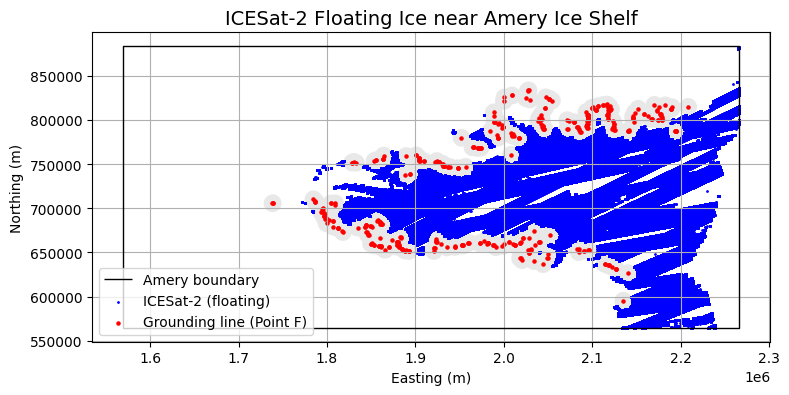

In [20]:
# visualize grounding zone/buffer on amery

fig, ax = plt.subplots(figsize=(8, 8))
# plot amery outline
amery_proj.boundary.plot(ax=ax, color='black', linewidth=1, label="Amery boundary")
# plot grounding line buffer
gpd.GeoSeries(buffer_union).plot(ax=ax, color='lightgray', alpha=0.5, label="10 km buffer (grounding zone)")
# plot filtered ICESat-2 points (floating only)
icesat2_floating_amery.plot(ax=ax, markersize=1, color='blue', label="ICESat-2 (floating)")

# add grounding line points for context
grounding_f_amery_proj = grounding_f_amery.to_crs("EPSG:3031")
grounding_f_amery_proj.plot(ax=ax, markersize=5, color='red', label="Grounding line (Point F)")

ax.set_title("ICESat-2 Floating Ice near Amery Ice Shelf", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.legend(loc='lower left')
ax.set_aspect("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
icesat2_floating_amery['h_li'].describe()

count    864860.000000
mean         77.381248
std          27.279455
min          11.073943
25%          65.543671
50%          84.454159
75%          98.452402
max         119.999985
Name: h_li, dtype: float64

In [21]:
# convert ICESat-2 height data to thickness

rho_s = 1027  # seawater density (kg/m^3)
rho_i = 918   # ice density (kg/m^3)
rho_a = 1     # firn-air density (kg/m^3)
Ha = 18.5       # firn-air column thickness (m) 

# hydrostatic ice thickness estimate from Chartrand+23
icesat2_floating_amery["H_E"] = (icesat2_floating_amery["h_li"] * (rho_s / (rho_s - rho_i)) -
    Ha * ((rho_i - rho_a) / (rho_s - rho_i)))

icesat2_floating_amery['H_E'][:5] 

6705731    816.686707
6705730    806.444702
6705729    806.877075
6705728    814.205811
6705727    810.229492
Name: H_E, dtype: float32

In [13]:
print(icesat2_floating_amery[['h_li', 'H_E']].describe())

                h_li            H_E
count  864860.000000  864860.000000
mean       77.381248     573.450256
std        27.279455     257.027527
min        11.073943     -51.298729
25%        65.543671     461.916000
50%        84.454159     640.090973
75%        98.452402     771.982666
max       119.999985     975.004333


In [22]:
# Bedmap shapePoints
folder = os.path.expanduser("/Users/abbyhartley/Desktop/glaciology/amery/bedmap_data")  # directory with .gpkg files
gpkg_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.gpkg')]
# load and combine all GPKG files
bedmap_points = gpd.GeoDataFrame(pd.concat([gpd.read_file(f) for f in gpkg_files], ignore_index=True))

# ensure same CRS before spatial comparison
bedmap_points = bedmap_points.to_crs(icesat2.crs)
print(f"Loaded {len(bedmap_points)} Bedmap3 points")
# now we can start comparing bedmap3 and ICESat-2 thickness data (for Amery specifically)

Loaded 1391485 Bedmap3 points


In [70]:
print(bedmap_points.columns)

Index(['Mean_thick', 'Med_thick', 'SD_thick', 'Cnt_thick', 'IQR_thick',
       'STE_thick', 'Min_thick', 'Max_thick', 'Mean_surf', 'Med_surf',
       'SD_surf', 'Cnt_surf', 'IQR_surf', 'STE_surf', 'Min_surf', 'Max_surf',
       'Mean_bed', 'Med_bed', 'SD_bed', 'Cnt_bed', 'IQR_bed', 'STE_bed',
       'Min_bed', 'Max_bed', 'Mean_dist', 'geometry', 'segment', 'Provider',
       'Campaign', 'Year'],
      dtype='object')


In [71]:
bedmap_points['Mean_thick'].describe()

count    1.389571e+06
mean     9.878608e+02
std      2.473549e+03
min     -9.999000e+03
25%      6.300000e+02
50%      1.230000e+03
75%      2.036000e+03
max      4.776000e+03
Name: Mean_thick, dtype: float64

In [23]:
# clean bedmap3 thickness data
bedmap_points = bedmap_points[(bedmap_points["Mean_thick"].notna()) &
    (bedmap_points["Mean_thick"] > 0) &
    (bedmap_points["Mean_thick"] < 2000)] 

bedmap_points['Mean_thick'][:5]

0    624.0
1    603.0
2    588.0
3    555.0
4    548.0
Name: Mean_thick, dtype: float64

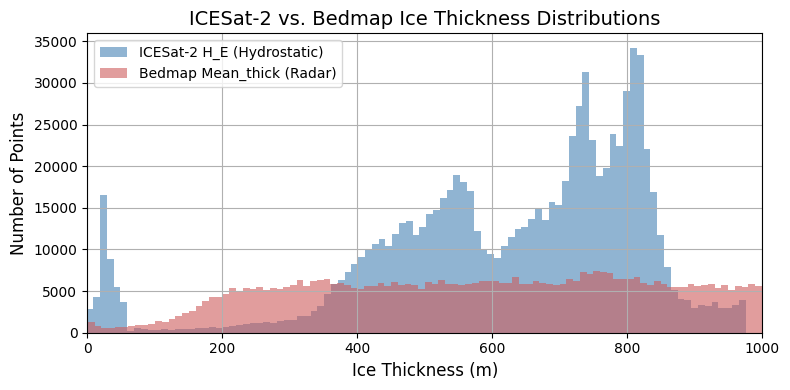

In [25]:
# make hist of bedmap thickness vs ours after masking out grounding line data

# extract thickness arrays
icesat_thickness = icesat2_floating_amery["H_E"]
bedmap_thickness = bedmap_points["Mean_thick"]

# plot histogram
plt.figure(figsize=(8, 4))
plt.hist(icesat_thickness, bins=100, alpha=0.6, label="ICESat-2 H_E (Hydrostatic)", color="indianred")
plt.hist(bedmap_thickness, bins=100, alpha=0.6, label="Bedmap Mean_thick (Radar)", color="steelblue")

plt.xlabel("Ice Thickness (m)", fontsize=12)
plt.ylabel("Number of Points", fontsize=12)
plt.title("ICESat-2 vs. Bedmap Ice Thickness Distributions", fontsize=14)
plt.xlim(0, 1000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
print(np.mean(icesat_thickness), np.mean(bedmap_thickness))

588.2549 573.1819523915584


## optimize rho_a and Ha to calibrate icesat2 to bedmap

In [26]:
# reproject ICESat-2 and Bedmap3 points to match Amery polygon CRS
icesat2_floating_amery = icesat2_floating_amery.to_crs(amery_poly.crs)
bedmap_points = bedmap_points.to_crs(amery_poly.crs)

# now we can safely clip!
icesat2_amery = gpd.clip(icesat2_floating_amery, amery_poly)
bedmap_amery = gpd.clip(bedmap_points, amery_poly)

print(bedmap_amery.columns)
print(icesat2_amery.columns)

Index(['Mean_thick', 'Med_thick', 'SD_thick', 'Cnt_thick', 'IQR_thick',
       'STE_thick', 'Min_thick', 'Max_thick', 'Mean_surf', 'Med_surf',
       'SD_surf', 'Cnt_surf', 'IQR_surf', 'STE_surf', 'Min_surf', 'Max_surf',
       'Mean_bed', 'Med_bed', 'SD_bed', 'Cnt_bed', 'IQR_bed', 'STE_bed',
       'Min_bed', 'Max_bed', 'Mean_dist', 'geometry', 'segment', 'Provider',
       'Campaign', 'Year'],
      dtype='object')
Index(['h_li', 'h_li_sigma', 'atl06_quality_summary', 'beam', 'date',
       'geometry', 'H_E'],
      dtype='object')


In [27]:
# test out a nearest neighbor match
from geopandas.tools import sjoin_nearest

# project to Antarctic Polar Stereographic (m) for a distance comparison
icesat2_amery_proj = icesat2_amery.to_crs("EPSG:3031")
bedmap_amery_proj = bedmap_amery.to_crs("EPSG:3031")

# nearest neighbor match
# remove invalid Bedmap3 points (no data)
bedmap_amery_valid = bedmap_amery_proj[bedmap_amery_proj['Mean_thick'] != -9999]
# rerun the spatial join
comparison = sjoin_nearest(icesat2_amery_proj[['geometry', 'H_E']],
    bedmap_amery_valid[['geometry', 'Mean_thick']],
    how='inner',
    distance_col='distance_m',
    max_distance=1000)

/var/folders/89/6rrshtw90nlcympj8jlq4pg00000gn/T/ipykernel_1384/2170374035.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('BM_IS2_overlap_6mo.png')
/Users/abbyhartley/miniforge3/envs/qgis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


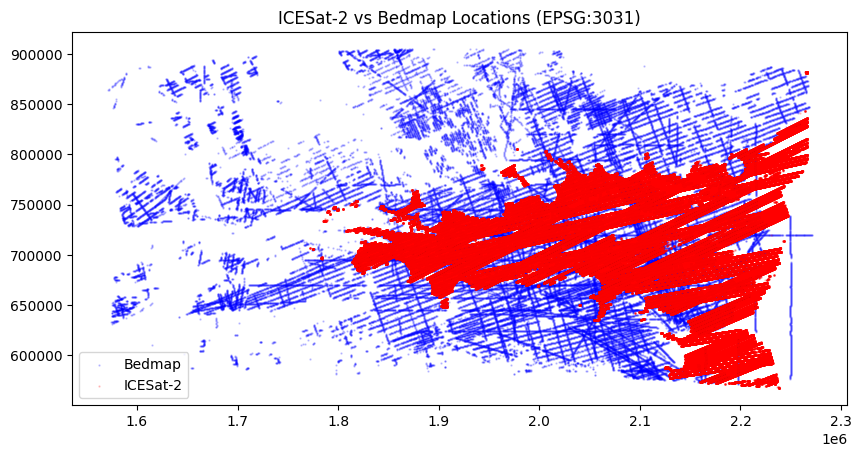

In [34]:
# visualize how icesat2 and bedmap3 data overlap
fig, ax = plt.subplots(figsize=(10, 10))
bedmap_amery_proj.plot(ax=ax, color='blue', markersize=0.5, alpha = 0.2, label='Bedmap')
icesat2_amery_proj.plot(ax=ax, color='red', markersize=0.5, alpha = 0.2, label='ICESat-2')
plt.legend()
plt.title("ICESat-2 vs Bedmap Locations (EPSG:3031)")
plt.savefig('BM_IS2_overlap_6mo.png')
plt.show()

In [20]:
print(len(icesat2_amery_proj))
print(len(bedmap_amery_proj))

print(icesat2_amery_proj.crs)
print(bedmap_amery_proj.crs)

853464
86949
EPSG:3031
EPSG:3031


In [84]:
print(comparison.shape)
print(comparison[['H_E', 'Mean_thick', 'distance_m']].dropna().head())

(470647, 5)
                H_E  Mean_thick  distance_m
2281206  934.781067       326.0  829.627148
2281205  831.164917       326.0  831.326781
2281204  745.431335       326.0  833.503554
2281203  696.133240       326.0  836.178338
2281202  709.626892       326.0  839.374941


/Users/abbyhartley/miniforge3/envs/qgis/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


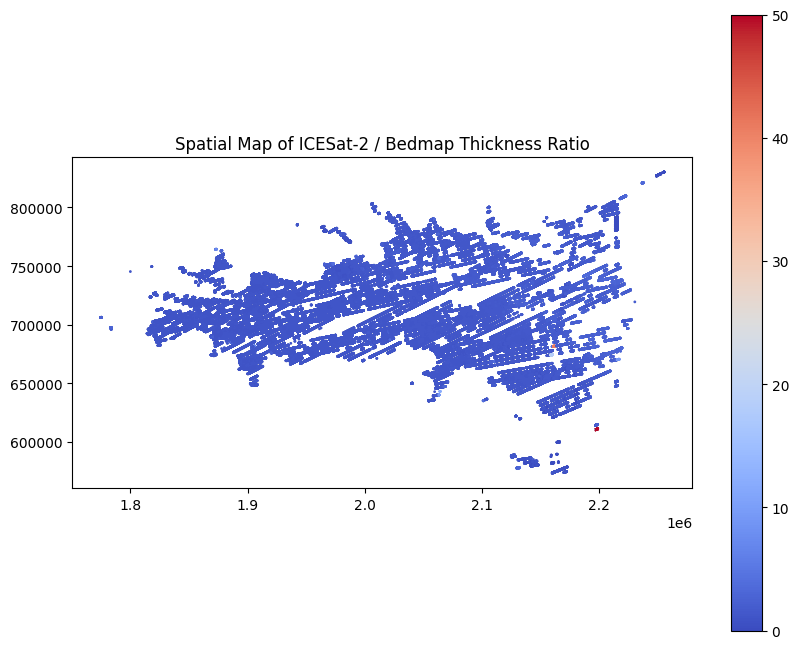

In [28]:
# filter out invalid or zero vals to avoid division errors
valid = comparison[(comparison['Mean_thick'] > 0) & (comparison['H_E'] > 0)]
valid['thick_ratio'] = valid['H_E'] / valid['Mean_thick']

/var/folders/89/6rrshtw90nlcympj8jlq4pg00000gn/T/ipykernel_1384/3943116482.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/89/6rrshtw90nlcympj8jlq4pg00000gn/T/ipykernel_1384/3943116482.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('is2_bm_orig_thick_comp.png')
/Users/abbyhartley/miniforge3/envs/qgis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


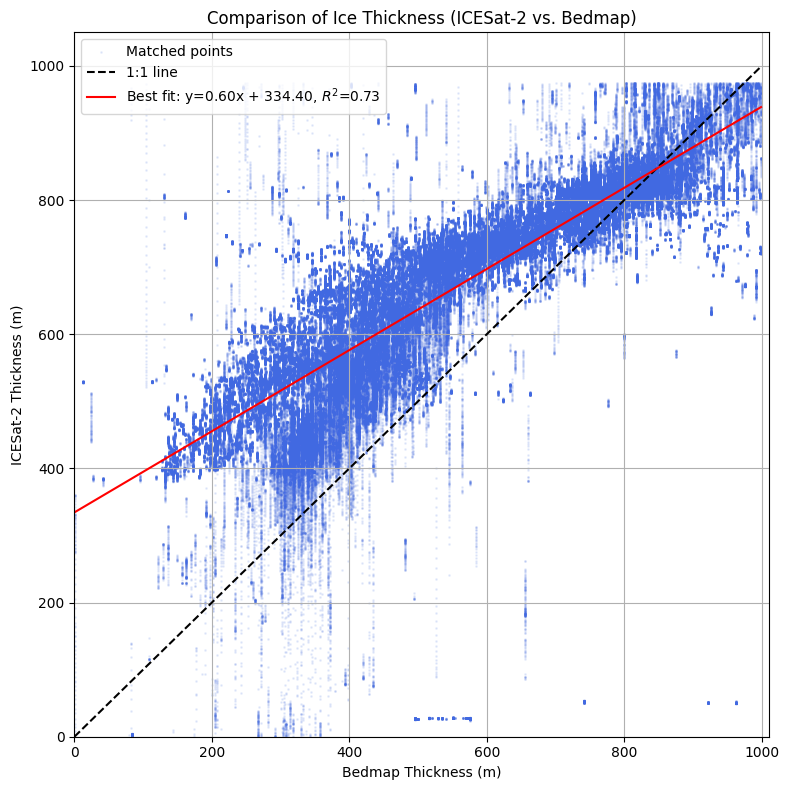

In [33]:
from sklearn.linear_model import LinearRegression

# extract valid matched data
bedmap_thick = valid['Mean_thick'].values.reshape(-1, 1)  # x-axis
icesat_thick = valid['H_E'].values.reshape(-1, 1)         # y-axis

# fit linear regression model 
reg = LinearRegression().fit(bedmap_thick, icesat_thick)
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]
r2 = reg.score(bedmap_thick, icesat_thick)

plt.figure(figsize=(8, 8))
plt.scatter(bedmap_thick, icesat_thick, s=1, alpha=0.1, c='royalblue', label='Matched points')
plt.plot([0, bedmap_thick.max()], [0, bedmap_thick.max()], 'k--', label='1:1 line')
plt.plot(
    [0, bedmap_thick.max()],
    [intercept, slope * bedmap_thick.max() + intercept],
    'r-', label=f'Best fit: y={slope:.2f}x + {intercept:.2f}, $R^2$={r2:.2f}')
plt.xlabel('Bedmap Thickness (m)')
plt.ylabel('ICESat-2 Thickness (m)')
plt.title('Comparison of Ice Thickness (ICESat-2 vs. Bedmap)')
plt.xlim(0, 1010)
plt.ylim(0, 1050)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/abbyhartley/miniforge3/envs/qgis/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


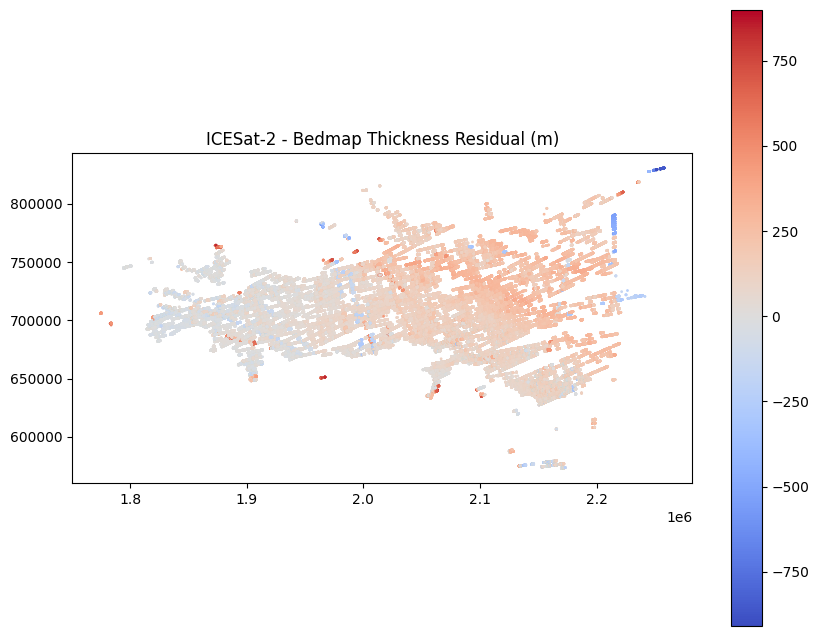

In [24]:
valid['residual'] = valid['H_E'] - valid['Mean_thick']
fig, ax = plt.subplots(figsize=(10, 8))
valid.plot(column='residual', cmap='coolwarm', legend=True, ax=ax, markersize=1)
ax.set_title('ICESat-2 - Bedmap Thickness Residual (m)')
plt.show()

In [41]:
# try varying Ha locally

# rerun the spatial join, including h_li this time
comparison = sjoin_nearest(
    icesat2_amery_proj[['geometry', 'H_E', 'h_li']], 
    bedmap_amery_valid[['geometry', 'Mean_thick']],
    how='inner',
    distance_col='distance_m',
    max_distance=1000)

# only for valid thickness comparisons
valid = comparison[(comparison['Mean_thick'] > 0) & (comparison['H_E'] > 0)]

# calculate spatial Ha needed for each point to match Bedmap
valid['Ha_local'] = ((valid['h_li'] * (rho_s / (rho_s - rho_i)) - valid['Mean_thick']) *
                     ((rho_s - rho_i) / (rho_i - rho_a)))
corrected_icesat = (valid['H_E'] - 340) / 0.6
icesat_thick = corrected_icesat.values.reshape(-1, 1)

/Users/abbyhartley/miniforge3/envs/qgis/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


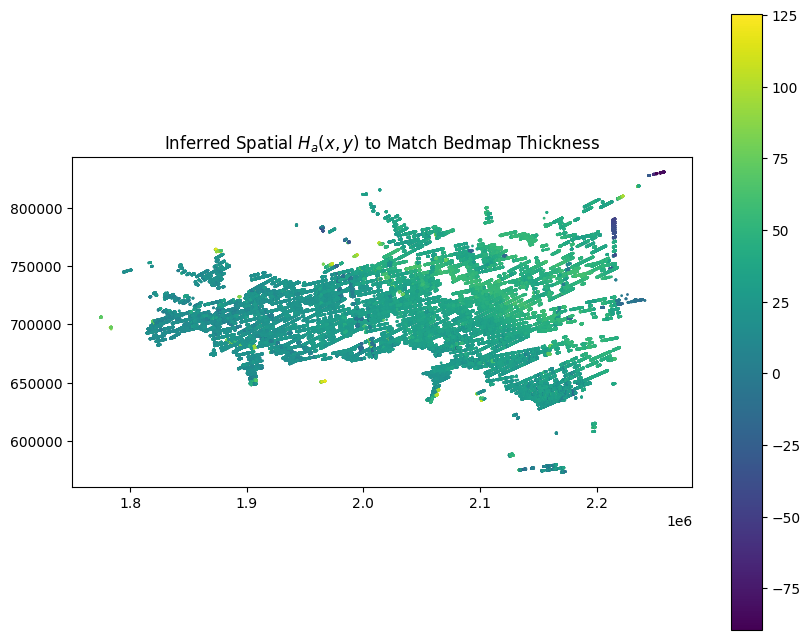

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
valid.plot(column='Ha_local', cmap='viridis', ax=ax, legend=True, markersize=1)
ax.set_title('Inferred Spatial $H_a(x, y)$ to Match Bedmap Thickness')
plt.show()

In [42]:
# recompute thickness 
valid['H_E_adjusted'] = (valid['h_li'] * (rho_s / (rho_s - rho_i)) -
                         valid['Ha_local'] * ((rho_i - rho_a) / (rho_s - rho_i)))

/Users/abbyhartley/miniforge3/envs/qgis/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [43]:
# check for improvement 

x = valid['Mean_thick'].values.reshape(-1, 1)
y = valid['H_E_adjusted'].values

model = LinearRegression().fit(x, y)
slope = model.coef_[0]
intercept = model.intercept_
r2 = r2_score(y, model.predict(x))

#print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}, R²: {r2:.3f}")

Slope: 1.00, Intercept: -0.00, R²: 1.000


/var/folders/89/6rrshtw90nlcympj8jlq4pg00000gn/T/ipykernel_39629/1158039769.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


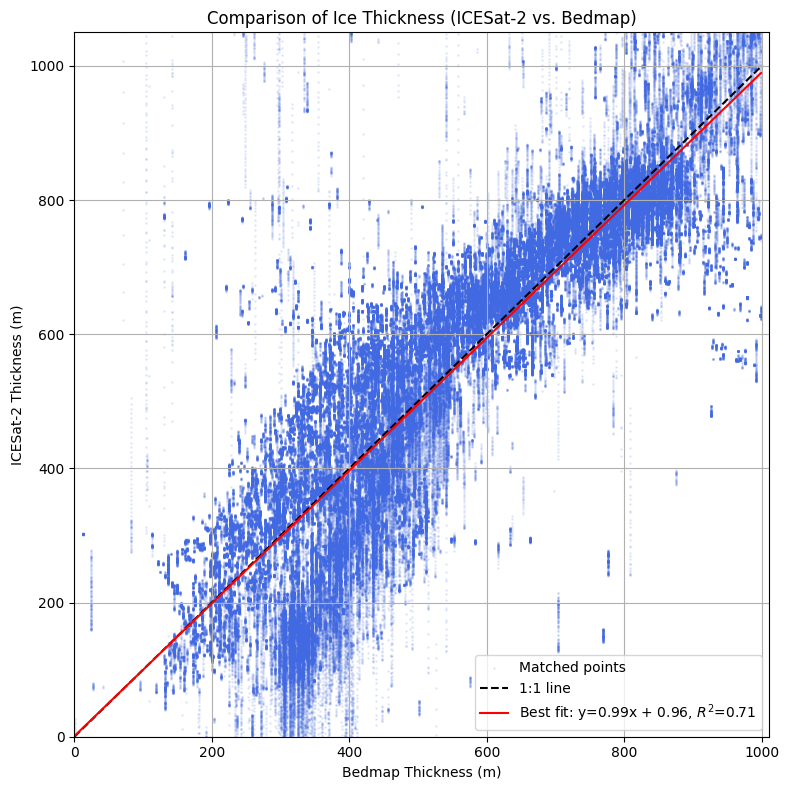

In [52]:
reg = LinearRegression().fit(bedmap_thick, icesat_thick)
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]
r2 = reg.score(bedmap_thick, icesat_thick)

plt.figure(figsize=(8, 8))
plt.scatter(bedmap_thick, icesat_thick, s=1, alpha=0.1, c='royalblue', label='Matched points')
plt.plot([0, bedmap_thick.max()], [0, bedmap_thick.max()], 'k--', label='1:1 line')
plt.plot(
    [0, bedmap_thick.max()],
    [intercept, slope * bedmap_thick.max() + intercept],
    'r-', label=f'Best fit: y={slope:.2f}x + {intercept:.2f}, $R^2$={r2:.2f}')
plt.xlabel('Bedmap Thickness (m)')
plt.ylabel('ICESat-2 Thickness (m)')
plt.title('Comparison of Ice Thickness (ICESat-2 vs. Bedmap)')
plt.ylim(0, 1050)
plt.xlim(0, 1010)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('icesat_bedmap_thickness_scatter.png')
plt.show()

In [57]:
# Calculate RMSD from the 1:1 line
rmsd = np.sqrt(mean_squared_error(bedmap_thick, icesat_thick))
print(f"RMSD from 1:1 line: {rmsd:.2f} m")

RMSD from 1:1 line: 133.26 m


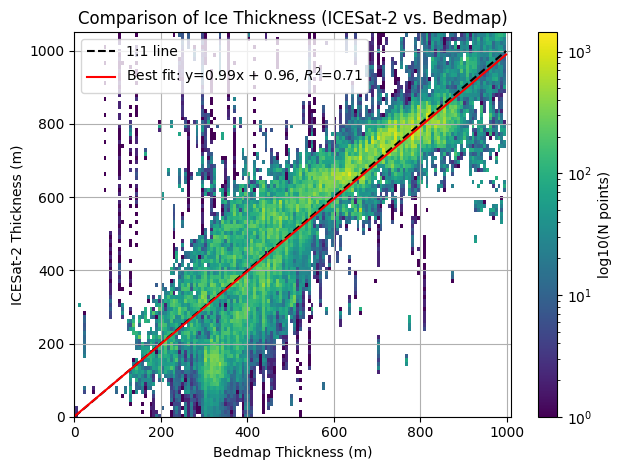

In [56]:
# linear regression model
reg = LinearRegression().fit(bedmap_thick, icesat_thick)
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]
r2 = reg.score(bedmap_thick, icesat_thick)

# plot with density
plt.hist2d(bedmap_thick.flatten(), icesat_thick.flatten(), bins=150, cmap='viridis', norm=LogNorm())
plt.colorbar(label='log10(N points)')

# 1:1 and best fit lines
xmax = bedmap_thick.max()
plt.plot([0, xmax], [0, xmax], 'k--', label='1:1 line')
plt.plot(
    [0, xmax],
    [intercept, slope * xmax + intercept],
    'r-', label=f'Best fit: y={slope:.2f}x + {intercept:.2f}, $R^2$={r2:.2f}')

plt.xlabel('Bedmap Thickness (m)')
plt.ylabel('ICESat-2 Thickness (m)')
plt.title('Comparison of Ice Thickness (ICESat-2 vs. Bedmap)')
plt.ylim(0, 1050)
plt.xlim(0, 1010)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('icesat_bedmap_thickness_density.png')
plt.show()

In [29]:
# save IceSAT-2 thickness data to new gpq 

# start with original ICESat-2 GeoDataFrame in EPSG:3031
icesat2_all = icesat2_floating_amery.copy()  # already projected to EPSG:3031 and cleaned

# valid df includes a subset of points with successful Bedmap matches
# filter to positive corrected thickness values
valid = valid[corrected_icesat > 0].copy()
valid["H_E_corrected"] = corrected_icesat[corrected_icesat > 0].values

# merge corrected thickness back into the full ICESat-2 GeoDataFrame by geometry
icesat2_all["H_E_corrected"] = pd.NA  # add empty column
icesat2_all.set_geometry("geometry", inplace=True)
valid.set_geometry("geometry", inplace=True)
icesat2_all = icesat2_all.merge(
    valid[["geometry", "H_E_corrected"]],
    on="geometry",
    how="left")

# set CRS to original (OGC:CRS84) and save
icesat2_all = icesat2_all.to_crs("OGC:CRS84")
icesat2_all.to_parquet("ICESat2_corrected_thickness.gpq")

print("saved ICESat-2 data with corrected thickness to 'ICESat2_corrected_thickness.gpq'!")

✅ Saved ICESat-2 data with corrected thickness to 'ICESat2_corrected_thickness.gpq'


In [30]:
icesat2_clean = gpd.read_parquet("ICESat2_corrected_thickness.gpq")
icesat2_clean.head()
icesat2_clean.crs  # should still be "OGC:CRS84"

<Geographic 2D CRS: OGC:CRS84>
Name: WGS 84 (CRS84)
Axis Info [ellipsoidal]:
- Lon[east]: Geodetic longitude (degree)
- Lat[north]: Geodetic latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
# drop unnecessary or duplicate columns
icesat2_clean = icesat2_clean.drop(columns=["H_E_corrected_x", "H_E_corrected_y"], errors="ignore")
icesat2_clean = icesat2_clean.rename(columns={"H_E": "H_E_corrected"})
# re-save the cleaned gpq
icesat2_clean.to_parquet("ATL06_thick.gpq")

In [34]:
icesat2_clean = icesat2_clean[icesat2_clean["H_E_corrected"] > 0].copy()
icesat2_clean.to_parquet("ATL06_thick.gpq")

In [35]:
icesat2_clean["H_E_corrected"].describe()

count    810315.000000
mean        613.278992
std         212.962845
min           0.001648
25%         499.230347
50%         664.376465
75%         778.247131
max         975.004333
Name: H_E_corrected, dtype: float64

In [36]:
icesat2_clean.describe()

,h_li,h_li_sigma,atl06_quality_summary,date,H_E_corrected
count,810315.000000,810315.000000,810315.0,810315,810315.000000
mean,81.608467,0.025268,0.0,2019-11-22 21:46:22.519652352,613.278992
min,16.518677,0.003548,0.0,2019-10-02 05:42:34,0.001648
25%,69.504005,0.010470,0.0,2019-10-23 04:35:18,499.230347
50%,87.031685,0.012397,0.0,2019-12-03 15:34:01,664.376465
75%,99.117275,0.019008,0.0,2019-12-20 01:47:20,778.247131
max,119.999985,0.991871,0.0,2019-12-29 13:52:44,975.004333
std,22.602678,0.044508,0.0,NaN,212.962845
